In [34]:
import pandas as pd
import matplotlib.pyplot as plt


In [35]:

# Load the CSV file
file_path = "/Users/mahdipashaei/Desktop/karma_convection_data/No_Convection_Countors.csv"
contours_data = pd.read_csv(file_path)
# Display the first few rows of the dataframe
print(contours_data.head())

   TimeStep  Time  Phi  Points:0  Points:1  Points:2
0         0   0.0    0    121.78    117.39         0
1         0   0.0    0    121.79    117.38         0
2         0   0.0    0    121.51    117.51         0
3         0   0.0    0    120.99    117.77         0
4         0   0.0    0    120.98    117.78         0


In [36]:
# Display basic statistics
print(contours_data.describe())

# Display column names
print(contours_data.columns)

# Display the data types of each column
print(contours_data.dtypes)

           TimeStep          Time        Phi      Points:0      Points:1  \
count  1.075247e+06  1.075247e+06  1075247.0  1.075247e+06  1.075247e+06   
mean   4.657378e+02  7.436665e+01        0.0  1.249825e+02  1.249818e+02   
std    2.044640e+02  3.271479e+01        0.0  2.911254e+01  2.910779e+01   
min    0.000000e+00  0.000000e+00        0.0  5.195500e+01  5.197100e+01   
25%    3.090000e+02  4.928800e+01        0.0  1.037700e+02  1.037700e+02   
50%    4.990000e+02  7.968800e+01        0.0  1.250000e+02  1.250000e+02   
75%    6.420000e+02  1.025700e+02        0.0  1.462300e+02  1.462300e+02   
max    7.610000e+02  1.216100e+02        0.0  1.977800e+02  1.977700e+02   

        Points:2  
count  1075247.0  
mean         0.0  
std          0.0  
min          0.0  
25%          0.0  
50%          0.0  
75%          0.0  
max          0.0  
Index(['TimeStep', 'Time', 'Phi', 'Points:0', 'Points:1', 'Points:2'], dtype='object')
TimeStep      int64
Time        float64
Phi           int

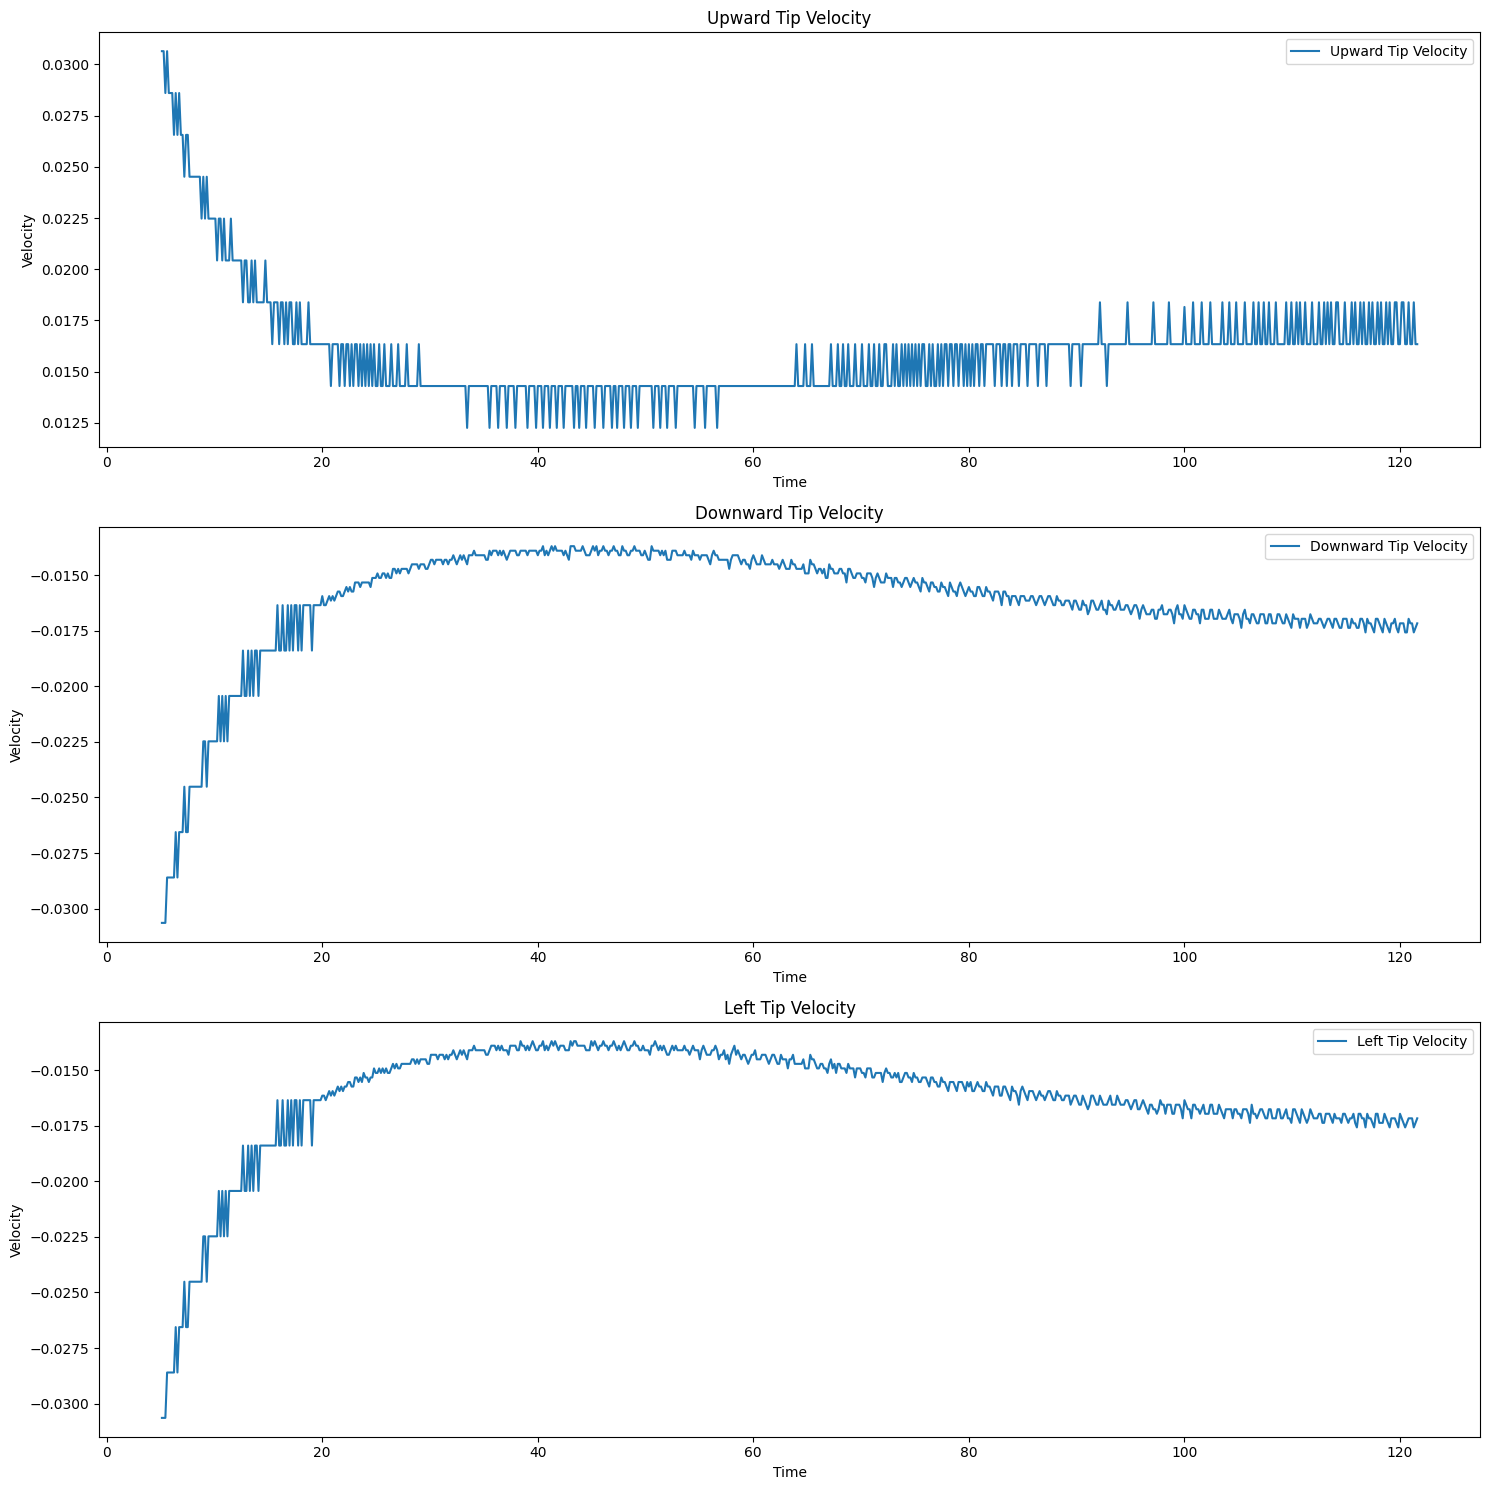

In [43]:
# Strip any leading/trailing whitespace from the column names
contours_data.columns = contours_data.columns.str.strip()

# Filter data where Phi is exactly 0 (interface)
interface_data_exact_zero = contours_data[contours_data['Phi'] == 0]

# Find the tip of the solid in the upward, downward, and left directions
# Assuming 'Time' and coordinates 'Points:0', 'Points:1', 'Points:2' (which likely correspond to X, Y, Z)

# Tip in the upward direction (max Y value)
upward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmax()]

# Tip in the downward direction (min Y value)
downward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmin()]

# Tip to the left (min X value)
left_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:0'].idxmin()]

# Calculate velocities for these tips
def calculate_velocity(tip_data, direction, coordinate):
    tip_data = tip_data.sort_values('Time')
    tip_data['Velocity_' + direction] = tip_data[coordinate].diff() / tip_data['Time'].diff()
    return tip_data

upward_tip_velocity = calculate_velocity(upward_tip, 'upward', 'Points:1')
downward_tip_velocity = calculate_velocity(downward_tip, 'downward', 'Points:1')
left_tip_velocity = calculate_velocity(left_tip, 'left', 'Points:0')

# Filter to include only times greater than 5
upward_tip_velocity = upward_tip_velocity[upward_tip_velocity['Time'] > 5]
downward_tip_velocity = downward_tip_velocity[downward_tip_velocity['Time'] > 5]
left_tip_velocity = left_tip_velocity[left_tip_velocity['Time'] > 5]




# Plot the velocities separately
plt.figure(figsize=(15, 15))

# Upward tip velocity
plt.subplot(3, 1, 1)
plt.plot(upward_tip_velocity['Time'], upward_tip_velocity['Velocity_upward'], label='Upward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Upward Tip Velocity')
plt.legend()

# Downward tip velocity
plt.subplot(3, 1, 2)
plt.plot(downward_tip_velocity['Time'], downward_tip_velocity['Velocity_downward'], label='Downward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Downward Tip Velocity')
plt.legend()

# Left tip velocity
plt.subplot(3, 1, 3)
plt.plot(left_tip_velocity['Time'], left_tip_velocity['Velocity_left'], label='Left Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Left Tip Velocity')
plt.legend()

plt.tight_layout()
plt.show()

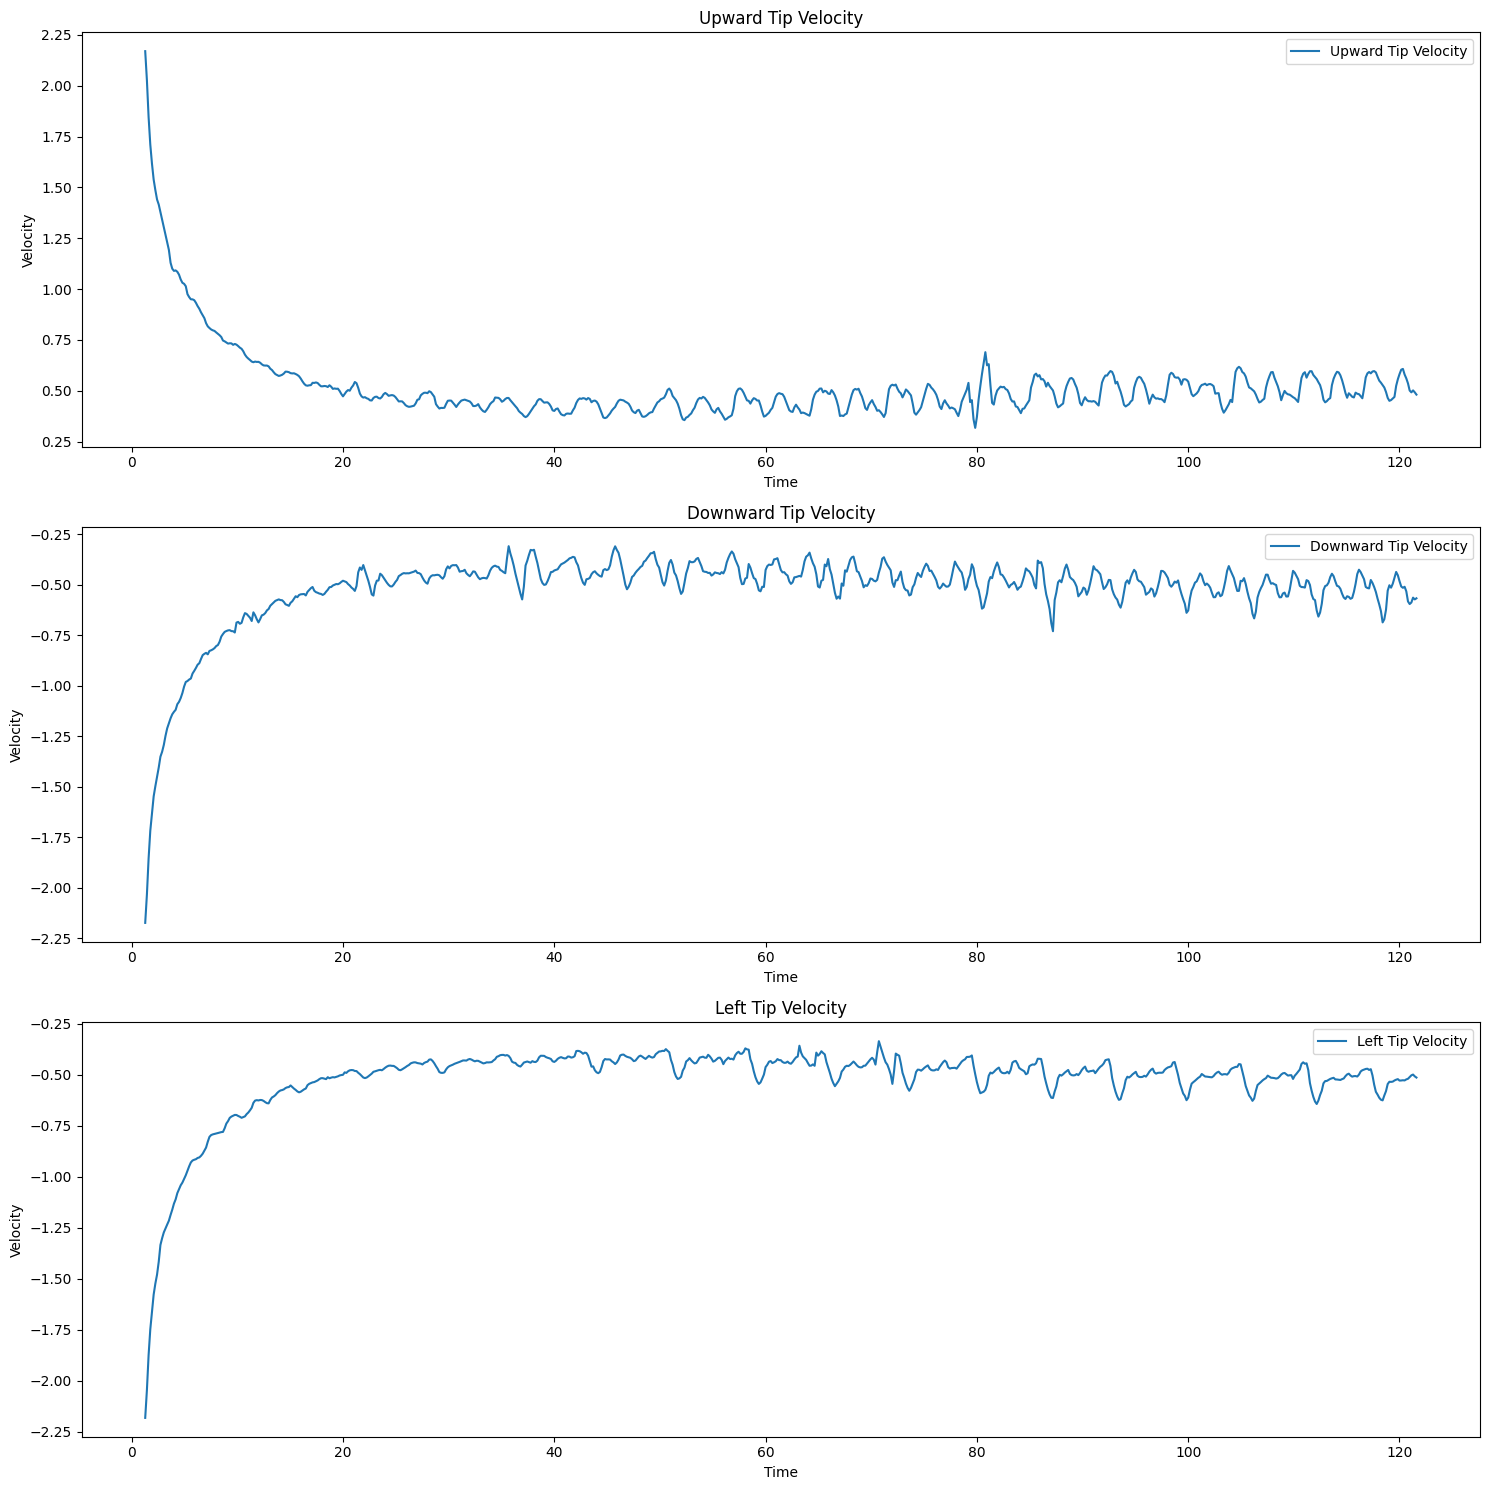

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

# Load the CSV file
file_path = "/Users/mahdipashaei/Desktop/karma_convection_data/No_Convection_Countors.csv"
contours_data = pd.read_csv(file_path)

# Strip whitespace from column names
contours_data.columns = contours_data.columns.str.strip()

# Filter data where Phi is exactly 0 (interface)
interface_data_exact_zero = contours_data[contours_data['Phi'] == 0]

# Apply exponential moving average
alpha = 0.3  # Smoothing factor
interface_data_exact_zero[['Points:0', 'Points:1']] = interface_data_exact_zero[['Points:0', 'Points:1']].ewm(alpha=alpha).mean()

# Find the tip of the solid in different directions
upward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmax()]
downward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmin()]
left_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:0'].idxmin()]

# Function to calculate velocity using linear regression over a window
def calculate_velocity_regression(tip_data, direction, coordinate):
    model = LinearRegression()
    velocities = []
    window_size = 10  # Number of points to consider in the regression
    times = tip_data['Time'].to_numpy().reshape(-1, 1)
    positions = tip_data[coordinate].to_numpy().reshape(-1, 1)
    
    for i in range(len(times) - window_size + 1):
        X = times[i:i+window_size]
        y = positions[i:i+window_size]
        model.fit(X, y)
        velocity = model.coef_[0][0]  # The slope of the regression line
        velocities.append(velocity)
    
    # Append NaNs to maintain the array length
    velocities = [np.nan] * (window_size - 1) + velocities
    tip_data['Velocity_' + direction] = velocities
    return tip_data

upward_tip_velocity = calculate_velocity_regression(upward_tip, 'upward', 'Points:1')
downward_tip_velocity = calculate_velocity_regression(downward_tip, 'downward', 'Points:1')
left_tip_velocity = calculate_velocity_regression(left_tip, 'left', 'Points:0')

# Plotting
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.plot(upward_tip_velocity['Time'], upward_tip_velocity['Velocity_upward'], label='Upward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Upward Tip Velocity')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(downward_tip_velocity['Time'], downward_tip_velocity['Velocity_downward'], label='Downward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Downward Tip Velocity')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(left_tip_velocity['Time'], left_tip_velocity['Velocity_left'], label='Left Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Left Tip Velocity')
plt.legend()

plt.tight_layout()
plt.show()


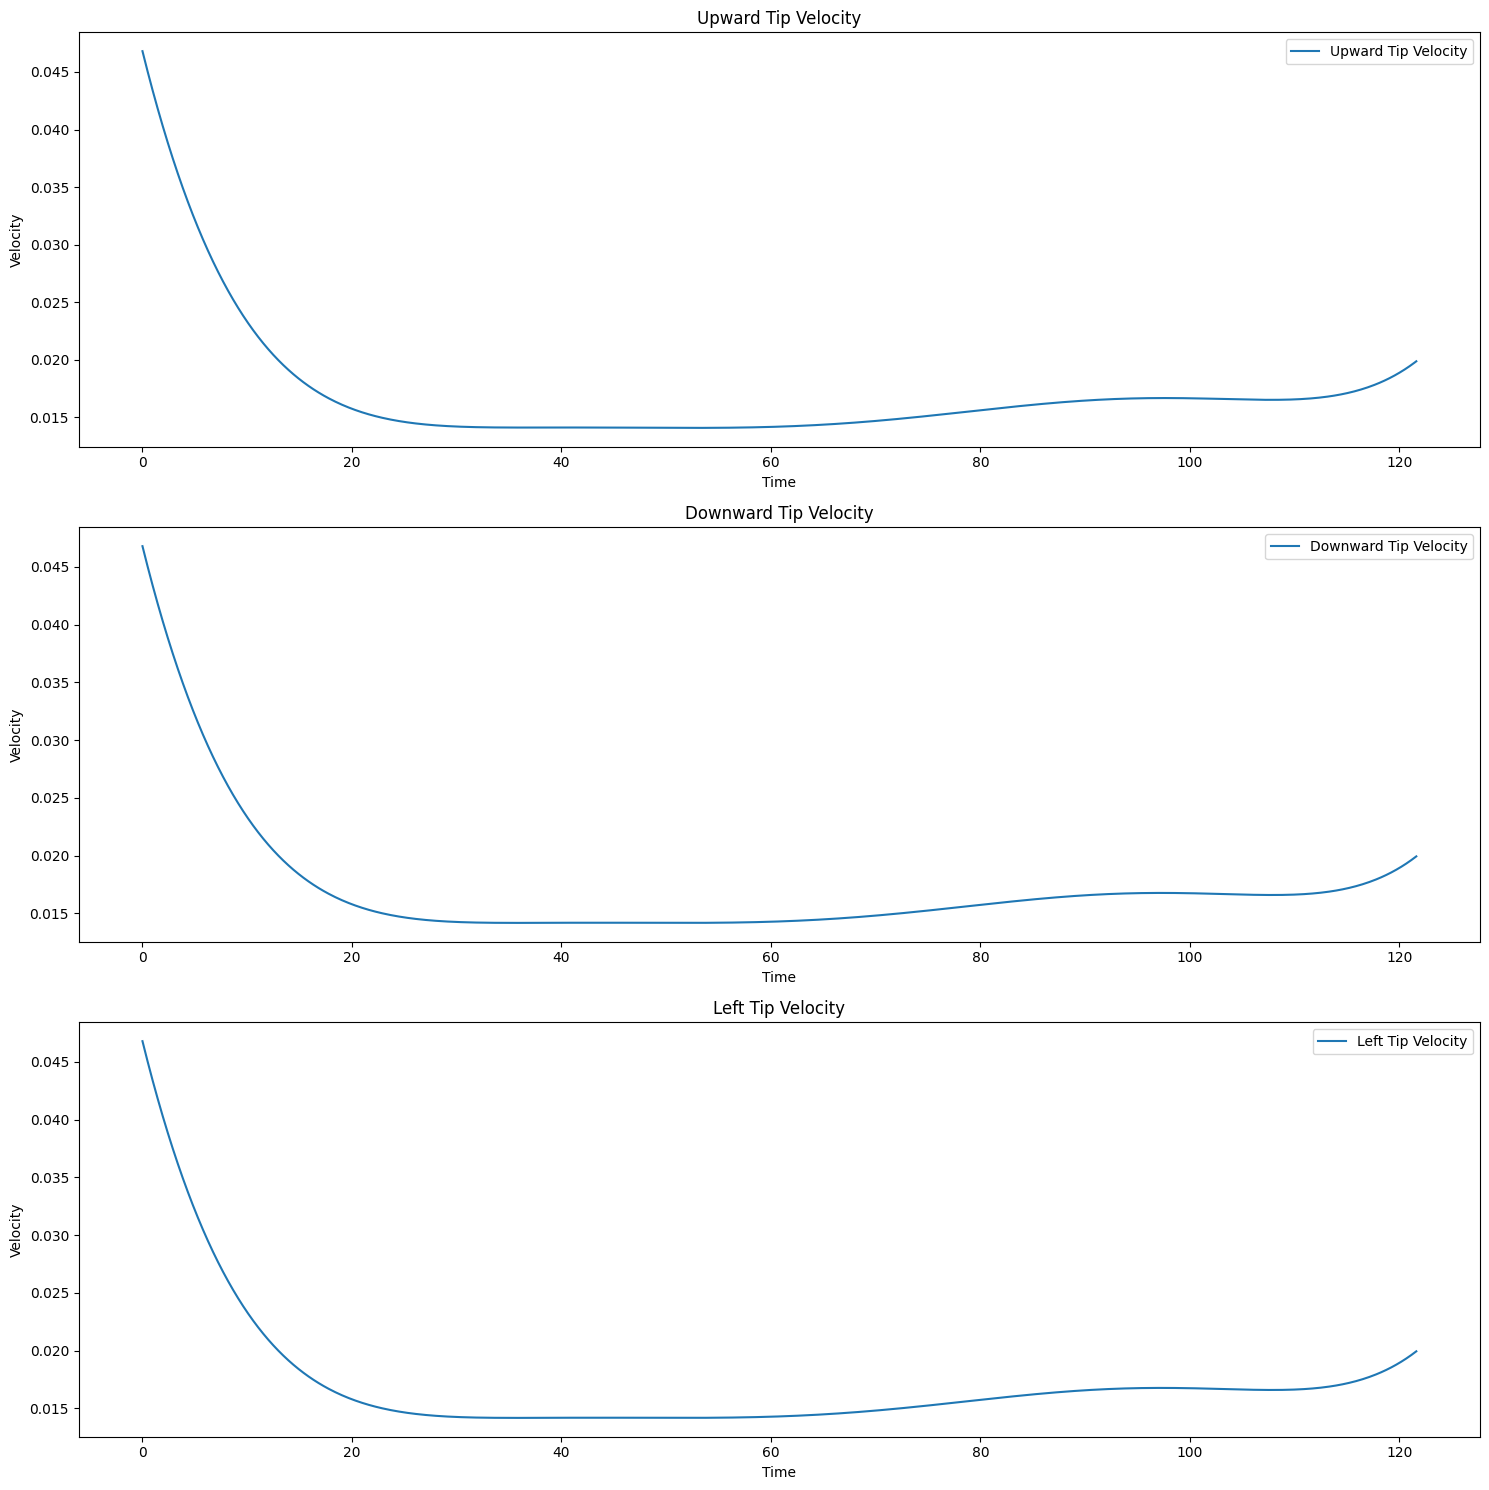

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Load the CSV file
file_path = "/Users/mahdipashaei/Desktop/karma_convection_data/No_Convection_Countors.csv"
contours_data = pd.read_csv(file_path)

# Strip whitespace from column names
contours_data.columns = contours_data.columns.str.strip()

# Filter data where Phi is exactly 0 (interface)
interface_data_exact_zero = contours_data[contours_data['Phi'] == 0]

# Find the tip of the solid in different directions
upward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmax()]
downward_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:1'].idxmin()]
left_tip = interface_data_exact_zero.loc[interface_data_exact_zero.groupby('Time')['Points:0'].idxmin()]

# Function to fit polynomial and calculate velocity
def calculate_velocity_polynomial(tip_data, direction, coordinate, degree=7):
    times = tip_data['Time'].to_numpy()
    positions = tip_data[coordinate].to_numpy()
    
    # Fit polynomial
    p = Polynomial.fit(times, positions, degree)
    
    # Calculate polynomial derivative
    dp = p.deriv()
    
    # Calculate velocities
    velocities = dp(times)
    tip_data['Velocity_' + direction] = velocities
    return tip_data

# Fit polynomials and calculate velocities for each tip direction
upward_tip_velocity = calculate_velocity_polynomial(upward_tip, 'upward', 'Points:1')
downward_tip_velocity = calculate_velocity_polynomial(downward_tip, 'downward', 'Points:1')
left_tip_velocity = calculate_velocity_polynomial(left_tip, 'left', 'Points:0')

# Divide all velocities by the specified value and take the absolute value
conversion_factor = 30.59273977746351
upward_tip_velocity['Velocity_upward'] = upward_tip_velocity['Velocity_upward'].abs() / conversion_factor
downward_tip_velocity['Velocity_downward'] = downward_tip_velocity['Velocity_downward'].abs() / conversion_factor
left_tip_velocity['Velocity_left'] = left_tip_velocity['Velocity_left'].abs() / conversion_factor


# Plotting
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.plot(upward_tip_velocity['Time'], upward_tip_velocity['Velocity_upward'], label='Upward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Upward Tip Velocity')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(downward_tip_velocity['Time'], downward_tip_velocity['Velocity_downward'], label='Downward Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Downward Tip Velocity')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(left_tip_velocity['Time'], left_tip_velocity['Velocity_left'], label='Left Tip Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Left Tip Velocity')
plt.legend()

plt.tight_layout()
plt.show()
